In [81]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Limitations in Data Set:
- Days 29-31 in not flood month are not considered so as to not skew the flood month data
- Equipment frequently malfunctions so rain is assumed to be zero. This is only done for a maximum of 4 day increments, however, could lead to an underestimation in rainfall.

In [82]:
#load data
df = pd.read_csv("RainGaugeData.csv")

In [83]:
# clean data

#identifying rainfall columns
rain_cols= [c for c in df.columns if "day" in c.lower()]

#fill missing values for malfunctioning equipment
df[rain_cols]= df[rain_cols].fillna(0)

#truncate for shorter month so not to skew with zeros
target_days= 28
rain_cols_28= rain_cols[:target_days]
# df[rain_cols_28] = df[rain_cols_28].astype(float)


In [84]:
# summary statistics
def compute_rainfall_summary_row(row):
    rain_values = row.values.astype(float)
    total = rain_values.sum()
    max_daily = rain_values.max()
    std = rain_values.std()
    heavy_days = (rain_values > 1).sum()
    rolling_3day = pd.Series(rain_values).rolling(3, min_periods=1).sum().max()
    rolling_7day = pd.Series(rain_values).rolling(7, min_periods=1).sum().max()
    return [total, max_daily, std, heavy_days, rolling_3day, rolling_7day]

rain_summary = pd.DataFrame(
    df[rain_cols_28].apply(compute_rainfall_summary_row, axis=1).tolist(),
    columns=summary_cols,
    index=df.index
)

df[summary_cols] = rain_summary

df[["gauge_id"] + ["month_type"] + summary_cols].round(2)

,gauge_id,month_type,total_rain_in,max_daily_rain_in,rain_std,heavy_days,rain_3day_max,rain_7day_max
0,G1,flooded,13.78,5.31,1.01,3,6.09,9.14
1,G2,flooded,14.00,5.38,1.02,3,6.20,9.49
2,G3,flooded,13.59,4.91,0.94,4,5.69,8.96
3,G4,flooded,12.04,5.45,1.05,2,6.19,8.03
4,G5,flooded,15.00,6.36,1.19,3,7.18,10.41
5,G6,flooded,12.14,4.23,0.81,2,5.18,7.68
6,G7,flooded,15.48,4.95,0.99,5,6.21,9.50
7,G8,flooded,10.80,4.35,0.82,3,4.95,7.43
8,G1,non_flooded,7.19,1.65,0.49,3,3.84,5.89
9,G2,non_flooded,6.58,2.00,0.49,3,2.58,4.77


Training accuracy: 1.0
Test accuracy: 1.0

Confusion Matrix:
[[1 0]
 [0 3]]


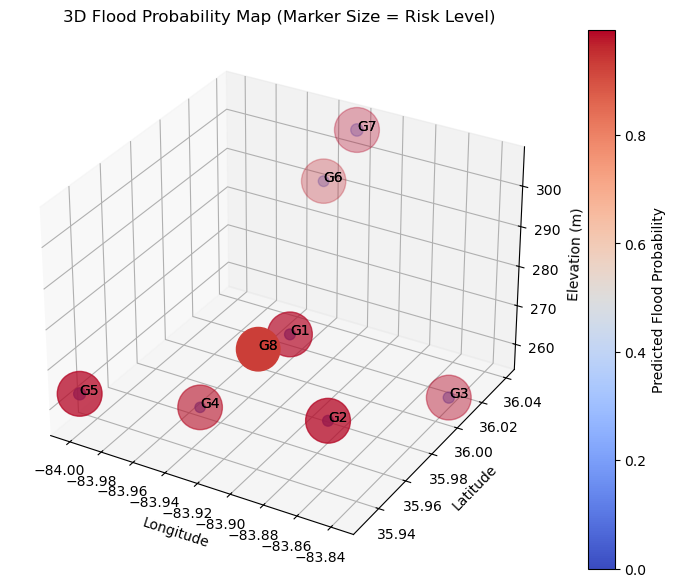

In [99]:
# create labels for RandomForest
features = ["lat", "long", "elev_m", "total_rain_in", "max_daily_rain_in",
            "rain_std", "heavy_days", "rain_3day_max", "rain_7day_max"]
X = df[features]
y = df["label"]

X_train, X_test, y_train, y_test=  train_test_split(
    X, y, test_size=0.25, random_state=42
)

# train RandomForest
rf = RandomForestClassifier(n_estimators=200, max_depth= 4, random_state= 42)
rf.fit(X_train,y_train)

train_acc = rf.score(X_train, y_train)
test_acc = rf.score(X_test, y_test)
print("Training accuracy:", train_acc)
print("Test accuracy:", test_acc)

y_pred = rf.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#predict probability
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Marker size based on predicted flood probability
sizes = df["pred_prob"] * 1000 + 50

# 3D scatter plot
sc = ax.scatter(df["long"], df["lat"],df["elev_m"], 
    s=sizes,c=df["pred_prob"], cmap='coolwarm' 
)

# Label each gauge
for _, row in df.iterrows():
    ax.text(
        row["long"], row["lat"], row["elev_m"], row["gauge_id"], 
    )

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Elevation (m)")
plt.title("3D Flood Probability Map (Marker Size = Risk Level)")
fig.colorbar(sc, label="Predicted Flood Probability")
plt.show()


training accuracy: 1.0
cross validation accuracy: 1.0


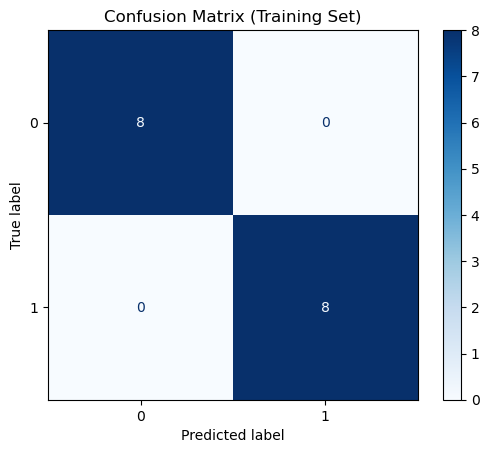

In [101]:
# create labels for RandomForest
features = ["lat", "long", "elev_m", "total_rain_in", "max_daily_rain_in",
            "rain_std", "heavy_days", "rain_3day_max", "rain_7day_max"]
X = df[features]
y = df["label"]

# train RandomForest
rf = RandomForestClassifier(n_estimators=200, max_depth= 4, random_state= 42)
rf.fit(X,y)

# training accuracy
y_train_pred = rf.predict(X)
train_acc = accuracy_score(y, y_train_pred)
print("training accuracy:", train_acc)

scores = cross_val_score(rf, X, y, cv=4)
print("cross validation accuracy:", scores.mean())

cm = confusion_matrix(y, y_train_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Training Set)")
plt.show()

In [102]:
# testing this- we'll use data from another month
new_data = {
    "lat": 35.5,
    "long": -120.7,
    "elev_m": 50,
    "total_rain_in": 2.3,
    "max_daily_rain_in": 1.2,
    "rain_std": 0.4,
    "heavy_days": 3,
    "rain_3day_max": 2.0,
    "rain_7day_max": 3.5
}

new_df = pd.DataFrame([new_data])

# Predict class (0 = no flood, 1 = flood)
flood_prediction = rf.predict(new_df)[0]
print("Flood Prediction:", "Yes" if flood_prediction == 1 else "No")

# Predict probability of flooding
flood_prob = rf.predict_proba(new_df)[0][1]
print(f"Flood Probability: {flood_prob:.2f}")

Flood Prediction: No
Flood Probability: 0.00


clearly model is wrong. thats the lowest elevation we have and it's saying no flood. will have to rework one of the training models\